In [1]:
import os
import random
import time
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from args import conf
from Autoencoder import *

if __name__== "__main__":
    # Option
    args = conf()
    print(args)

    if args.lmdb:
        from DataLoaderLMDB import Dataset_
    else:
        from DataLoader import Dataset_
    
    # Processing time
    starttime = time.time()
    today = datetime.now()
    weight_folder= "/" + today.strftime('%Y%m%d') + str(today.hour) + str(today.minute)

    # GPUs
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    #to deterministic
    cudnn.deterministic = True
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    
    # Training settings
    train_transform = transforms.Compose([transforms.RandomCrop((args.crop_size, args.crop_size)),
                                          transforms.ToTensor()])
    if args.lmdb:
        def init_lmdb_worker(lmdb_file):
            return lmdb.open(lmdb_file, readonly=True, lock=False, readahead=False, meminit=False)
        def collate_fn(batch):
            return batch
        train_dataset = Dataset_(args.path2traindb, transform=train_transform)
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
    else:
        train_dataset = Dataset_(args.path2traindb, transform=train_transform)
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
    
    if args.val:
        val_transform = transforms.Compose([transforms.RandomCrop((args.crop_size, args.crop_size)),
                                            transforms.ToTensor()])
        val_dataset = Dataset_(args.path2valdb, transform=val_transform)
        val_loader = DataLoader(val_dataset, batch_size=args.val_batch_size, shuffle=False, num_workers=args.num_workers)
    
    # Initialize model, optimizer, and loss function
    model = Network(args).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    
    scaler = torch.cuda.amp.GradScaler()
    num_epochs = args.epochs
    train_losses = []
    batch_losses = []
    accumulation_steps = 4  # Number of steps to accumulate gradients
    
    def save_checkpoint(state, filename):
        torch.save(state, filename)
        print(f"Checkpoint saved to {filename}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()  # Reset gradients
        for i, imgs in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            imgs = imgs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, imgs)
                loss = loss / accumulation_steps  # Normalize loss for accumulation

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Reset gradients
                torch.cuda.empty_cache()  # Clear memory

            running_loss += loss.item() * imgs.size(0)
            batch_losses.append(loss.item() * imgs.size(0))

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        if (epoch + 1) % args.save_interval == 0:
            os.makedirs(f"./data/weight/{args.usenet}" + weight_folder, exist_ok=True)
            checkpoint_filename = f"./data/weight/{args.usenet}{weight_folder}/checkpoint_epoch_{epoch+1}.pth.tar"
            save_checkpoint({
                'epoch': epoch + args.start_epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'batch_losses': batch_losses,
            }, checkpoint_filename)
            print(f"Model checkpoint saved at epoch {epoch+1}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        # Processing time
        endtime = time.time()
        interval = endtime - starttime
        print("elapsed time = {0:d}h {1:d}m {2:d}s".format(int(interval/3600), int((interval%3600)/60), int((interval%3600)%60)))
        # Clear unused memory
        torch.cuda.empty_cache()

    print("Training completed.")
    # Processing time
    endtime = time.time()
    interval = endtime - starttime
    print("elapsed time = {0:d}h {1:d}m {2:d}s".format(int(interval/3600), int((interval%3600)/60), int((interval%3600)%60)))


Namespace(batch_size=64, crop_size=256, dataset='rwave-1024', epochs=90, gpu_id=-1, img_size=256, lmdb=True, log_interval=100, lr=0.01, momentum=0.9, no_cuda=False, no_multigpu=False, num_workers=8, numof_classes=1000, path2testdb='./data/rwave-1024/test_images', path2traindb='./data/rwave-1024/rwave-1024.lmdb', path2valdb='./data/rwave-1024/val_images', path2weight='./data/weight', resume='', save_interval=1, seed=1, start_epoch=1, usenet='resnet50', val=False, val_batch_size=256, weight_decay=0.0001)


Epoch 1/90:   0%|          | 1/16000 [00:35<159:57:30, 35.99s/it]


Error: Caught Error in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "d:\anaconda3\envs\ML\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "d:\anaconda3\envs\ML\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\anaconda3\envs\ML\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "d:\FAU\SS24\Retinal Waves Project\Unsupervised Learning using ReWaRD\Pretraining\DataLoaderLMDB.py", line 24, in __getitem__
    env = lmdb.open(self.lmdb_file, readonly=True)
lmdb.Error: ./data/rwave-1024/rwave-1024.lmdb: No such file or directory


In [1]:
import os
import random
import time
from datetime import datetime
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from args import conf
from Autoencoder import *

In [45]:
torch.rand(1).item()

0.8049390912055969

In [2]:
import lmdb

lmdb_file='./data/rwave-1024/rwave-1024.lmdb'
env = lmdb.open(lmdb_file, readonly=True)

In [1]:
checkpoint_filename = f"data/weight/resnet50/checkpoint_epoch_30.pth.tar"
save_checkpoint({
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_losses': train_losses,
    'batch_losses': batch_losses,
}, checkpoint_filename)
print(f"Model checkpoint saved at epoch {epoch+1}")

NameError: name 'save_checkpoint' is not defined

In [2]:
import torch
from Autoencoder import *
from args import conf
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
args = conf()
model = Network(args)
checkpoint = torch.load('data/weight/resnet18/checkpoint_epoch_50.pth.tar')

# Adjust the keys of state_dict if necessary
state_dict = checkpoint['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '')
    new_state_dict[new_key] = v

# Load state_dict into the model
model.load_state_dict(new_state_dict)
args.start_epoch = checkpoint['epoch'] + 1
train_losses = checkpoint.get('train_losses', [])
batch_losses = checkpoint.get('batch_losses', [])
val_batch_losses = checkpoint.get('val_batch_losses', [])
val_losses = checkpoint.get('val_losses', [])
print("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))

=> loaded checkpoint '' (epoch 50)


In [2]:
val_losses

[0.0146269291456944,
 0.012841091859154403,
 0.011325056019316737,
 0.010236132838763297,
 0.00944126289182653,
 0.008194054497289471,
 0.007460143167797166,
 0.006886242098892883,
 0.006650632585515268,
 0.006441354306492334,
 0.005471802144214355,
 0.005414413833641447,
 0.005338094511049955,
 0.005268864887960565,
 0.005240407066885382,
 0.005171099294287463,
 0.005120479038353854,
 0.005085122112650425,
 0.0049844581194338385,
 0.0049720599126885645,
 0.004967556025949307,
 0.004963927306816913,
 0.004959884885659752,
 0.004947594381131543,
 0.0049426478378397105,
 0.004940495259361342,
 0.004947472677934759,
 0.004942017176072113,
 0.004941643852604708,
 0.0049444967449138255,
 0.004940582069587738,
 0.004937966677243821,
 0.004935291610988012,
 0.004943172935066589,
 0.004942548126370336,
 0.004937859947191706,
 0.004938799944842079,
 0.004936938581231516,
 0.004938609953193615,
 0.004938056971101711,
 0.004937026154754373,
 0.0049354104003092895,
 0.004946742953616194,
 0.004950

Text(0, 0.5, 'Loss')

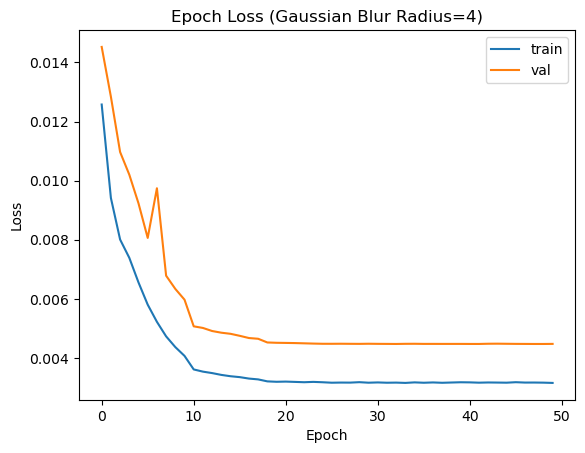

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])
plt.title('Epoch Loss (Gaussian Blur Radius=4)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [5]:
train_losses[-1]

0.001109531009105922

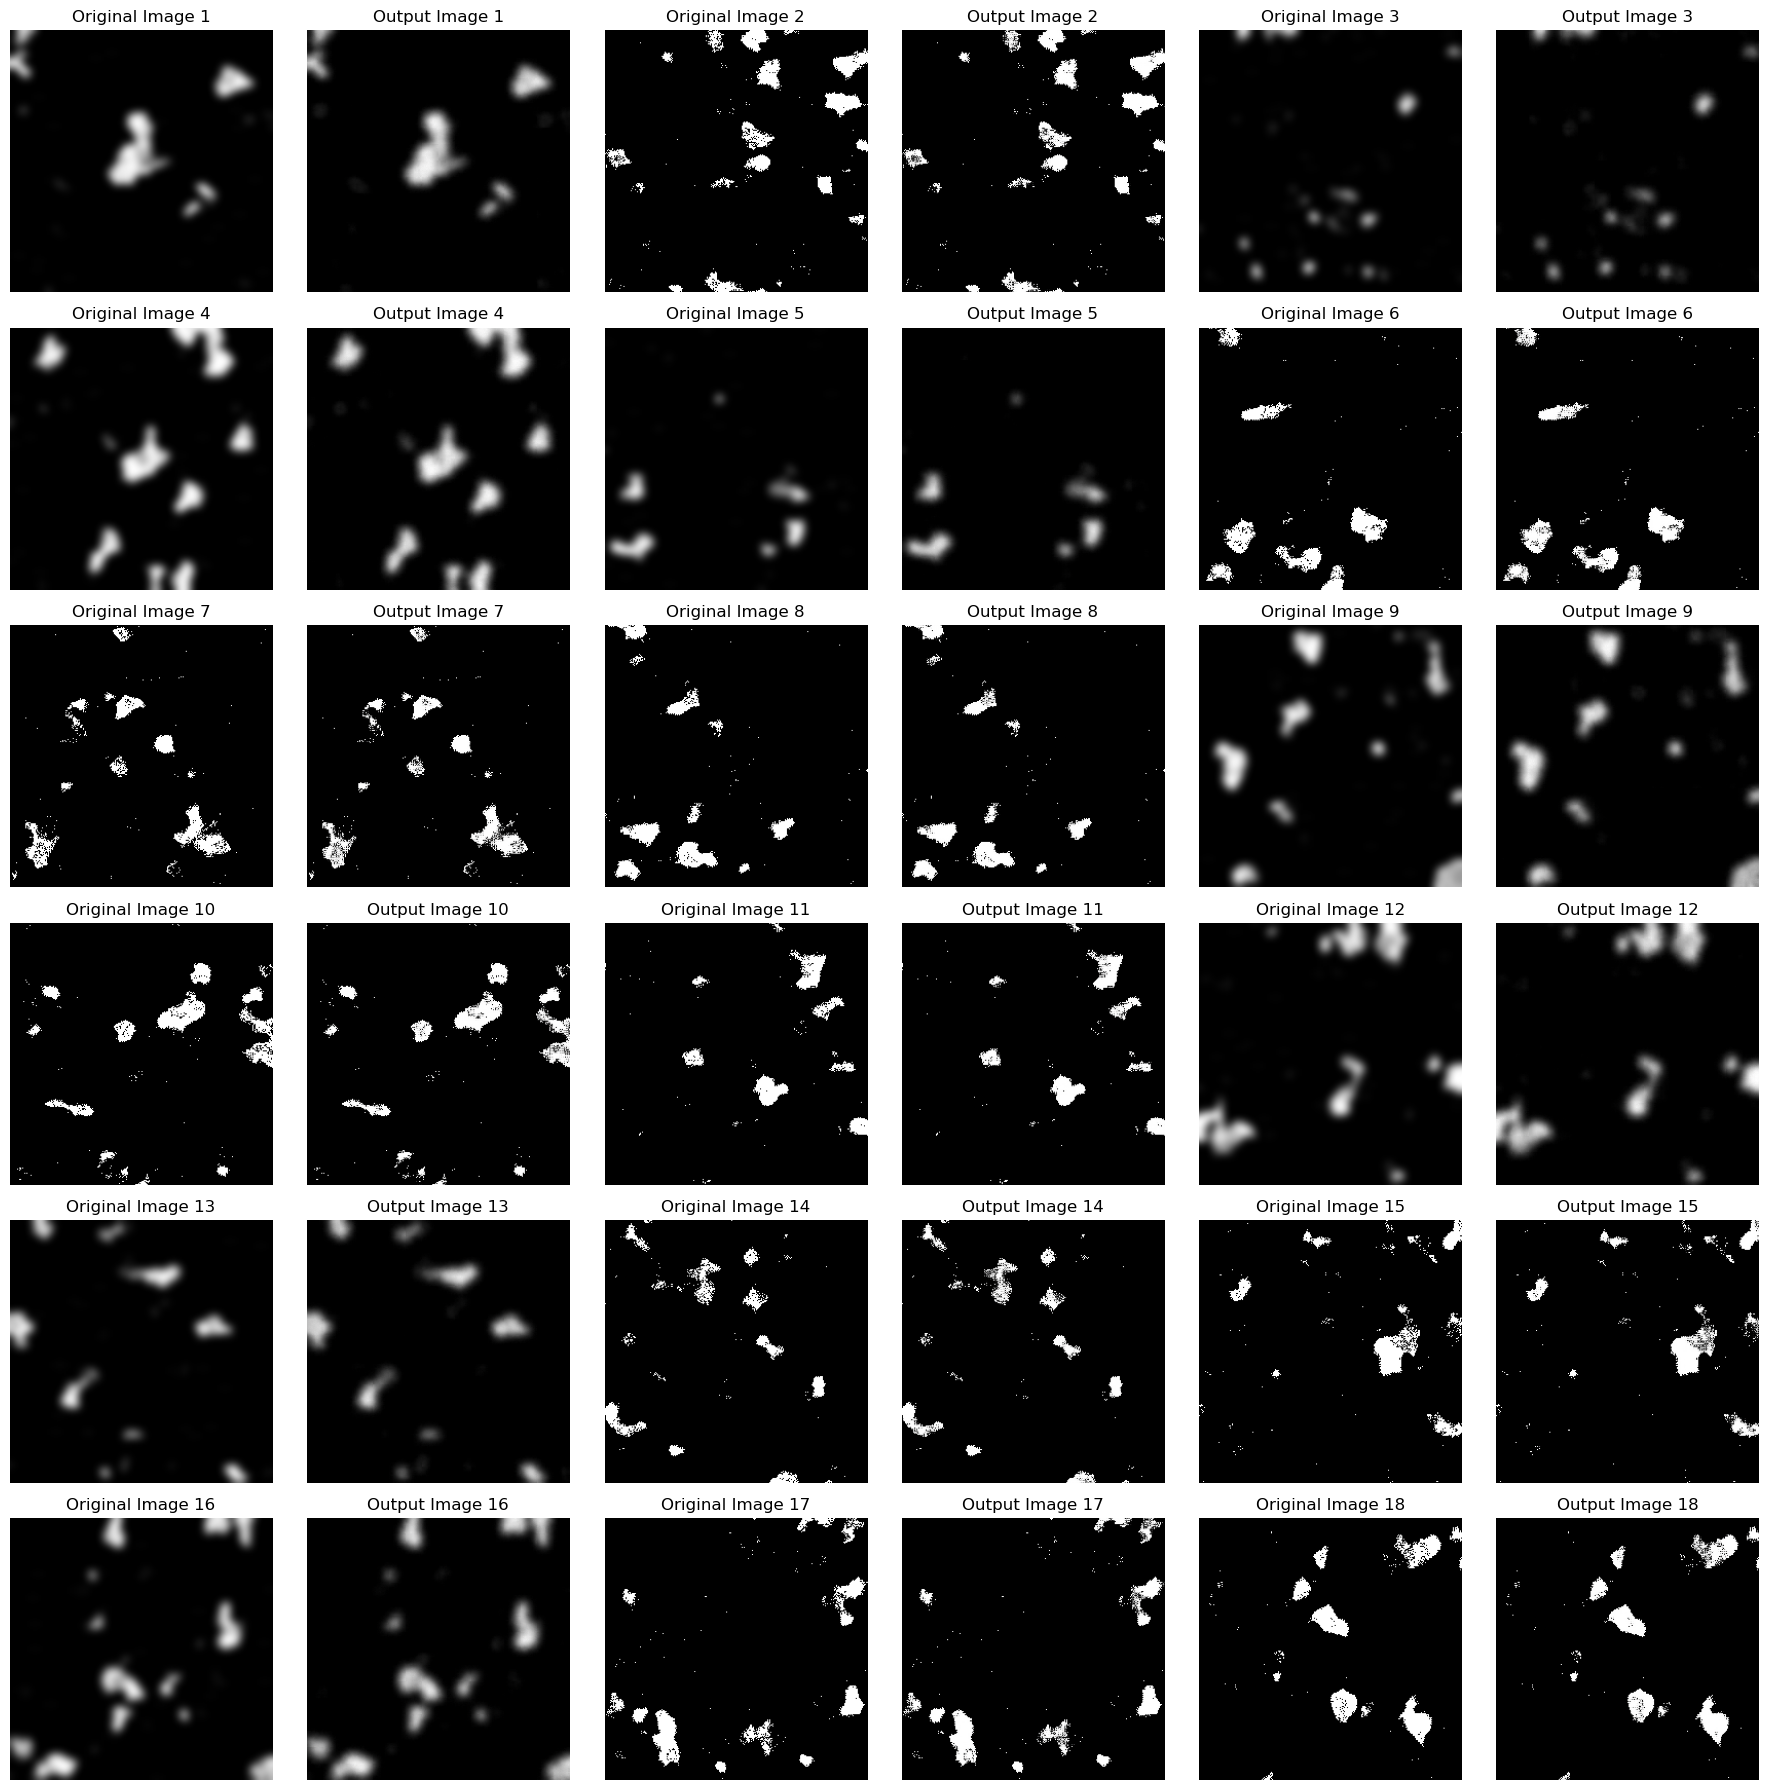

In [6]:
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFilter
from torchvision import transforms
import os
import numpy as np

# Assuming you have the model properly defined and initialized
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RandomGaussianBlur(object):
    def __init__(self, probability=0.3, radius=2):
        self.probability = probability
        self.radius = radius

    def __call__(self, img):
        if torch.rand(1).item() < self.probability:
            return img.filter(ImageFilter.GaussianBlur(radius=self.radius))
        return img

# Define your image transformations
transform = transforms.Compose([
    transforms.Resize((args.crop_size, args.crop_size)),  
    RandomGaussianBlur(probability=0.5, radius=4),
    transforms.ToTensor()
])

# Path to the directory containing the images
image_dir = 'data/rwave-1024/train_images/'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Sample the first 18 images
sample_files = [image_files[i] for i in np.random.permutation(len(image_files))[:18]]

# Create a subplot with 3 rows and 6 columns (3 rows x 6 images per row)
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()
model = model.to(device)
model.eval()
for i, image_file in enumerate(sample_files):
    # Read and process the image
    img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = Image.fromarray(img)
    img = transform(img)
    img = img.to(device)
    # Forward pass through the model
    out = model(img.unsqueeze(0))

    # Process the output
    out = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Original image
    original_img = img.permute(1, 2, 0).cpu().numpy()

    # Plot original image
    ax_orig = axes[i * 2]
    ax_orig.imshow(original_img)
    ax_orig.set_title(f'Original Image {i+1}')
    ax_orig.axis('off')

    # Plot output image
    ax_out = axes[i * 2 + 1]
    ax_out.imshow(out)
    ax_out.set_title(f'Output Image {i+1}')
    ax_out.axis('off')

plt.tight_layout()
plt.show()
